## 历史上指数涨幅超过3%的后续情况

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
/mnt/datadisk2/aglv/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
index = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/index_data/open.csv')
index

,Unnamed: 0,20050104,20050105,20050106,20050107,20050110,20050111,20050112,20050113,20050114,...,20231031,20231101,20231102,20231103,20231106,20231107,20231108,20231109,20231110,20231113
0,905,996.682,986.570,1003.490,993.434,996.928,1006.211,1008.010,1008.098,1012.699,...,5547.3243,5534.8883,5514.5172,5462.1440,5549.2909,5594.4667,5602.9707,5602.4900,5577.3371,5589.0595
1,852,996.278,989.873,1014.965,1005.515,1011.925,1024.036,1026.741,1024.132,1028.990,...,6003.3650,5969.8069,5958.4770,5895.6017,6007.4341,6088.5110,6114.9873,6135.0718,6079.4732,6107.2693
2,300,994.769,981.577,993.331,983.045,983.760,994.189,996.651,996.078,996.617,...,3581.6759,3605.7576,3580.0672,3558.5303,3608.3187,3623.7849,3610.6434,3603.1082,3596.0688,3593.9109
3,16,836.988,825.707,831.989,822.669,823.766,833.209,837.357,836.170,834.354,...,2409.8949,2456.3813,2429.7186,2419.6868,2452.8399,2450.2667,2436.8736,2428.5080,2424.4922,2415.9565


In [14]:
hs300 = index.iloc[2, 1:]

hs300.index = [str(i) for i in hs300.index]
hs300.index.names = ['date']


In [26]:
hs300 = hs300.loc['20100101':]

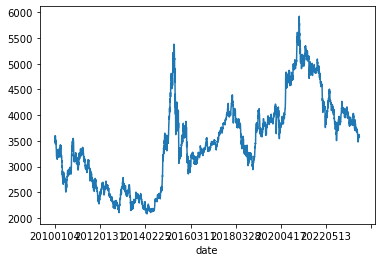

In [27]:
hs300.plot()

In [44]:
hs300_ret = hs300 / hs300.shift(1) -1
date_up = hs300[hs300_ret > 0.03].index

In [51]:
is_up = []
for date in date_up:
    date_id = hs300.index.get_loc(date)
    is_up.append(int(np.where(hs300[date_id + 8]/hs300[date_id] > 1, 1, -1)))
np.mean(is_up)
    

0.045454545454545456

In [52]:
# for date in date_up:
#     date_id = hs300.index.get_loc(date)
    
#     plt.plot(hs300.iloc[date_id - 2 : date_id + 3])
#     plt.show()

In [92]:
def factors_corr(factor_folder):
    import glob, os
    import seaborn as sns

    csv_path = glob.glob(os.path.join(factor_folder, '*.csv'))
    # new_path = []
    # for p in csv_path:
    #     f_name = p.split('/')[-1][:-4]
    #     if 'relu' in f_name:
    #         new_path.append(p)
    
    # new_path = new_path[:8]
    new_path = csv_path.copy()

    dfs = [pd.read_csv(f) for f in new_path]
    for df in dfs:
        if 'date' in df.columns:
            df = df.set_index('date')
        elif 'Date' in df.columns:
            df = df.set_index('Date')

    num = len(dfs)
    print(num)

    corrs = pd.DataFrame(index=range(num), columns=range(num))
    for i in range(num):
        print(i, new_path[i].split('/')[-1][:-4])
        for j in range(num):
            if j < i:
                corrs.iloc[i, j] = corrs.iloc[j ,i]
            elif j == i:
                corrs.iloc[i, j] = 1
            else:
                corrs.iloc[i, j] = dfs[i].corrwith(dfs[j]).mean()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corrs.astype(float), annot=True, cmap='Greens', fmt=".2f")
    plt.title('Correlation with Means Heatmap')
    plt.show()

5
0 relu_nightret_r15mean_vol_zs_corr_r15
1 relu_nightret_r5mean_vol_zs_dot_r15
2 relu_indayret_r15sum_vol_zs_dot_r15
3 price_vol_weight_corr_v2_ret0_r15_day
4 turnstd_agg5min_noavg_21_23_min


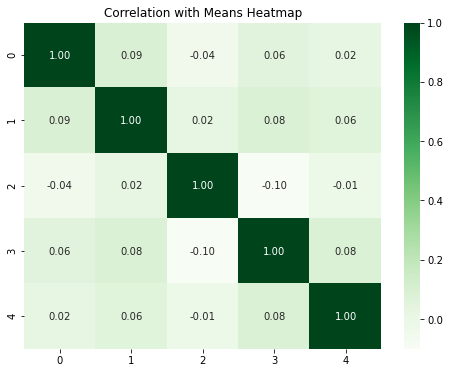

In [93]:
factors_corr('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep_bertter')

In [94]:
turn_std_agg5 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep_bertter/turnstd_agg5min_noavg_21_23_min.csv')


In [95]:
def check_extrme_factor(factor:pd.DataFrame, date, rolling_day=10, is_large=True, check_num=10, check_period=5):
    '''
    检测某天的极端因子值的股票表现
    因子值按照向前rolling 10天的平均值进行排序 绘图显示前后5天的股票表现, 在jupyter中检测
    需要用到datadaily类获取日频价格数据
    '''

    if 'date' in factor.columns:
        factor = factor.set_index('date')
    elif 'Date' in factor.columns:
        factor = factor.set_index('Date')

    if date not in factor.index:
        raise ValueError('日期为非交易日')

    factor = factor.rolling(10).mean()
    factor_date = factor.loc[date]
    factor_date_sorted = factor_date.sort_values().dropna()

    if is_large:
        check_stock = factor_date_sorted.iloc[-check_num:].index
    else:
        check_stock = factor_date_sorted.iloc[:check_num].index
    
    close = datadaily.adjclose
    for stock in check_stock:
        date_id = close.index.get_loc(date)
        p_date = close.iloc[date_id-check_period:date_id+check_period+1, :].loc[:, stock]
        p_date.index = [str(i) for i in p_date.index]

        plt.plot(p_date)
        plt.title(stock)
        plt.show()